# Binary Group Composition on $D_n$ (Dihedral Group)

**Group:** Dihedral group $D_n$ of order $2n$ (rotations and reflections of a regular $n$-gon).  
**Task:** Given encodings of two group elements $g_1, g_2 \in D_n$, predict the encoding of their product $g_1 \cdot g_2$.  
**Sequence length:** $k = 2$ (binary composition).  
**Architecture:** `TwoLayerNet` with square nonlinearity.  
**Key result:** The network learns one irreducible representation at a time, producing a staircase in the training loss.

## Imports

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from escnn.group import DihedralGroup
from torch.utils.data import DataLoader, TensorDataset

import src.dataset as dataset
import src.model as model
import src.optimizer as optimizer
import src.power as power
import src.template as template
import src.train as train_mod
import src.viz as viz

## Configuration

In [2]:
TEST_MODE = os.environ.get("NOTEBOOK_TEST_MODE", "0") == "1"

seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

n = 3  # D_3 has order 2*3 = 6
group = DihedralGroup(n)
group_size = group.order()

hidden_size = 20 if TEST_MODE else 180
epochs = 2 if TEST_MODE else 5000
lr = 0.01
init_scale = 1e-3

FIGURES_DIR = "figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

print(f"Group: D_{n}, order {group_size}")

Group: D_3, order 6


## Template and Dataset

In [3]:
# Build a template with known Fourier structure on D_n
# D_3 has 3 irreps with dimensions [1, 1, 2]
# Well-separated powers for clean staircase learning
powers = [0.0, 30.0, 3000.0]

# Convert desired powers to Fourier coefficient diagonal values
# (matching src/main.py custom_fourier logic)
irreps = group.irreps()
irrep_dims = [ir.size for ir in irreps]
fourier_coef_diag_values = [
    np.sqrt(group_size * p / dim**2) if p > 0 else 0.0
    for p, dim in zip(powers, irrep_dims)
]
print(f"Desired powers: {powers}")
print(f"Irrep dims: {irrep_dims}")
print(f"Fourier coef diag values: {[f'{v:.3f}' for v in fourier_coef_diag_values]}")

tpl = template.fixed_group(group, fourier_coef_diag_values)

# Build exhaustive dataset: all group_size^2 pairs
X, Y = dataset.group_dataset(group, tpl)
X_tensor, Y_tensor, device = dataset.move_dataset_to_device_and_flatten(X, Y)

ds = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(ds, batch_size=len(ds), shuffle=False)

print(f"Dataset: {len(ds)} samples (all {group_size}x{group_size} pairs)")
print(f"X shape: {X_tensor.shape}, Y shape: {Y_tensor.shape}")

Desired powers: [0.0, 30.0, 3000.0]
Irrep dims: [1, 1, 2]
Fourier coef diag values: ['0.000', '13.416', '67.082']
mat for irrep 0 of dimension 1 is:
 [[0.]]

mat for irrep 1 of dimension 1 is:
 [[13.41640786]]

mat for irrep 2 of dimension 2 is:
 [[67.08203932  0.        ]
 [ 0.         67.08203932]]

GPU is available. Using CUDA.
Dataset: 36 samples (all 6x6 pairs)
X shape: torch.Size([36, 12]), Y shape: torch.Size([36, 6])


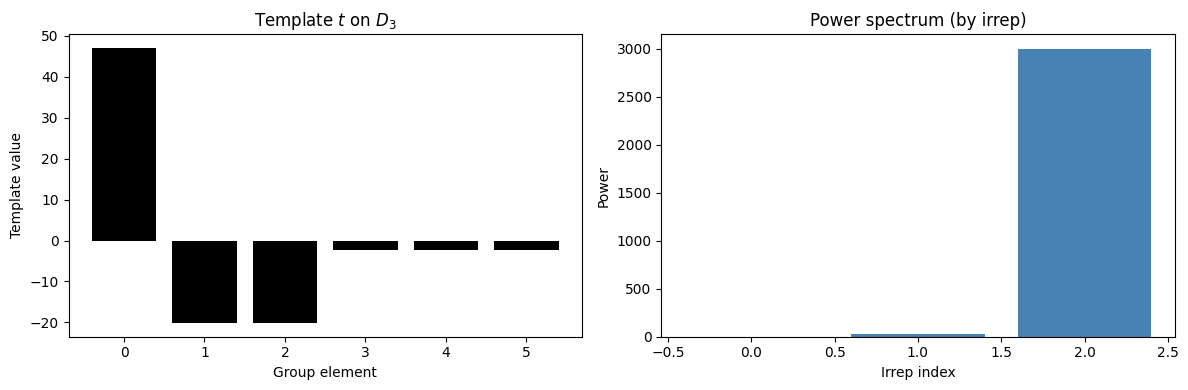

In [4]:
# Visualize template and its group power spectrum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(group_size), tpl, color="black")
ax1.set_xlabel("Group element")
ax1.set_ylabel("Template value")
ax1.set_title(f"Template $t$ on $D_{{{n}}}$")

gp = power.GroupPower(tpl, group)
pwr = gp.group_power_spectrum()
ax2.bar(range(len(pwr)), pwr, color="steelblue")
ax2.set_xlabel("Irrep index")
ax2.set_ylabel("Power")
ax2.set_title("Power spectrum (by irrep)")

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/dn_template.pdf", bbox_inches="tight")
plt.show()

## Model and Optimizer

In [5]:
net = model.TwoLayerNet(
    group_size=group_size,
    hidden_size=hidden_size,
    nonlinearity="square",
    init_scale=init_scale,
)
net = net.to(device)

criterion = nn.MSELoss()
opt = optimizer.PerNeuronScaledSGD(net, lr=lr)  # degree auto-inferred as 2 for TwoLayerNet

print(f"Model: TwoLayerNet(group_size={group_size}, hidden={hidden_size}, init_scale={init_scale})")
print(f"Optimizer: PerNeuronScaledSGD(lr={lr}, degree={opt.param_groups[0]['degree']})")
print(f"Training for {epochs} epochs")

Model: TwoLayerNet(group_size=6, hidden=180, init_scale=0.001)
Optimizer: PerNeuronScaledSGD(lr=0.01, degree=2)
Training for 5000 epochs


## Training

In [6]:
loss_history, val_loss_history, param_history, param_save_epochs, final_epoch = train_mod.train(
    net,
    dataloader,
    criterion,
    opt,
    epochs=epochs,
    verbose_interval=max(1, epochs // 10),
    grad_clip=0.1,
    save_param_interval=1,
)

[Epoch   500/5000] loss: 5.032102 | reduction:   99.0%
[Epoch  1000/5000] loss: 5.044927 | reduction:   99.0%
[Epoch  1500/5000] loss: 5.060741 | reduction:   99.0%
[Epoch  2000/5000] loss: 5.080063 | reduction:   99.0%
[Epoch  2500/5000] loss: 5.103499 | reduction:   99.0%
[Epoch  3000/5000] loss: 5.127010 | reduction:   99.0%
[Epoch  3500/5000] loss: 5.137788 | reduction:   99.0%
[Epoch  4000/5000] loss: 5.143885 | reduction:   99.0%
[Epoch  4500/5000] loss: 5.136471 | reduction:   99.0%
[Epoch  5000/5000] loss: 5.138467 | reduction:   99.0%


## Training Loss

Computing loss plateau predictions for template of shape: (6,)
Found  2 non-zero power coefficients.


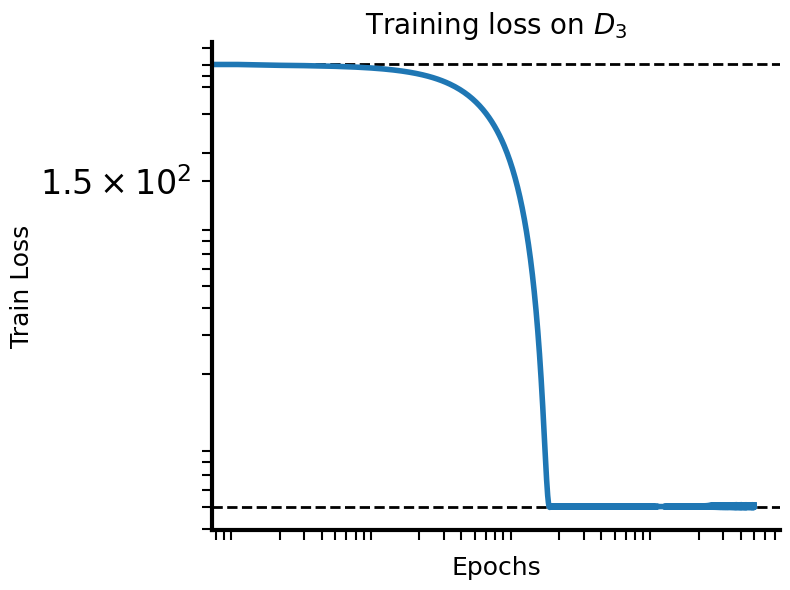

In [7]:
# Compute theoretical loss plateau levels
theory_levels = gp.loss_plateau_predictions()

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(loss_history, lw=4)

for level in theory_levels:
    ax.axhline(y=level, color="black", linestyle="--", linewidth=2, zorder=-2)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Epochs", fontsize=18)
ax.set_ylabel("Train Loss", fontsize=18)
ax.set_title(f"Training loss on $D_{{{n}}}$", fontsize=20)
viz.style_axes(ax)
ax.grid(False)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/dn_loss.pdf", bbox_inches="tight")
plt.show()

## Power Spectrum Over Training

Computing power at step 1 with output shape (1, 6)
Computing power at step 61 with output shape (1, 6)
Computing power at step 83 with output shape (1, 6)
Computing power at step 114 with output shape (1, 6)
Computing power at step 156 with output shape (1, 6)
Computing power at step 213 with output shape (1, 6)
Computing power at step 291 with output shape (1, 6)
Computing power at step 398 with output shape (1, 6)
Computing power at step 544 with output shape (1, 6)
Computing power at step 744 with output shape (1, 6)
Computing power at step 1016 with output shape (1, 6)
Computing power at step 1389 with output shape (1, 6)
Computing power at step 1899 with output shape (1, 6)
Computing power at step 2595 with output shape (1, 6)
Computing power at step 3546 with output shape (1, 6)
Computing power at step 4846 with output shape (1, 6)


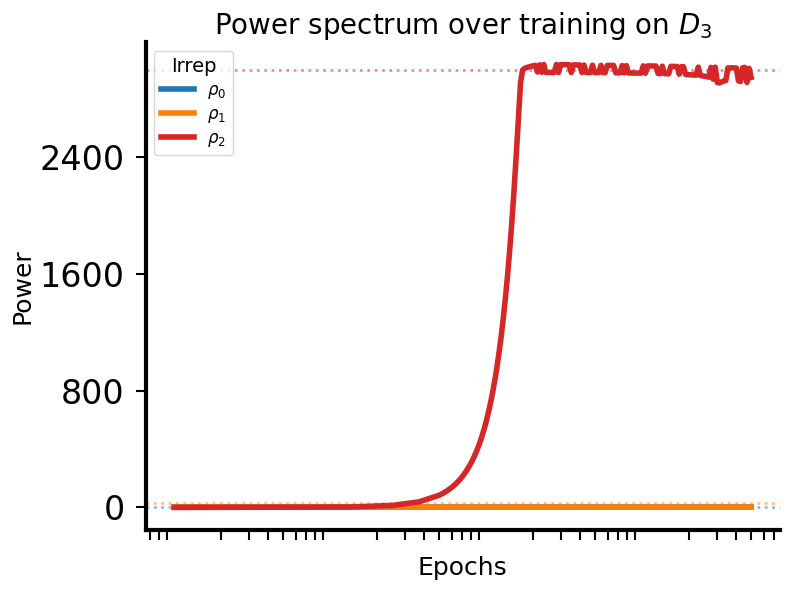

In [8]:
# Use model_power_over_time from src/power.py
powers_over_time, power_steps = power.model_power_over_time(
    group_name="dihedral",
    model=net,
    param_history=param_history,
    model_inputs=X_tensor,
    group=group,
)

# Reference: template power per irrep
template_pwr = gp.group_power_spectrum()

# Plot
colors = ["tab:blue", "tab:orange", "tab:red", "tab:green", "tab:brown", "tab:purple"]
fig, ax = plt.subplots(figsize=(8, 6))

n_irreps = powers_over_time.shape[1]
for k in range(n_irreps):
    color = colors[k] if k < len(colors) else f"C{k}"
    ax.plot(power_steps, powers_over_time[:, k], color=color, lw=4, label=rf"$\rho_{{{k}}}$")
    ax.axhline(template_pwr[k], color=color, linestyle="dotted", linewidth=2, alpha=0.5, zorder=-10)

ax.set_xscale("log")
ax.set_ylabel("Power", fontsize=18)
ax.set_xlabel("Epochs", fontsize=18)
ax.set_title(f"Power spectrum over training on $D_{{{n}}}$", fontsize=20)
ax.legend(fontsize=12, title="Irrep", title_fontsize=14, loc="upper left", labelspacing=0.25)
viz.style_axes(ax)
ax.grid(False)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/dn_power_spectrum.pdf", bbox_inches="tight")
plt.show()

## Irreducible Representations

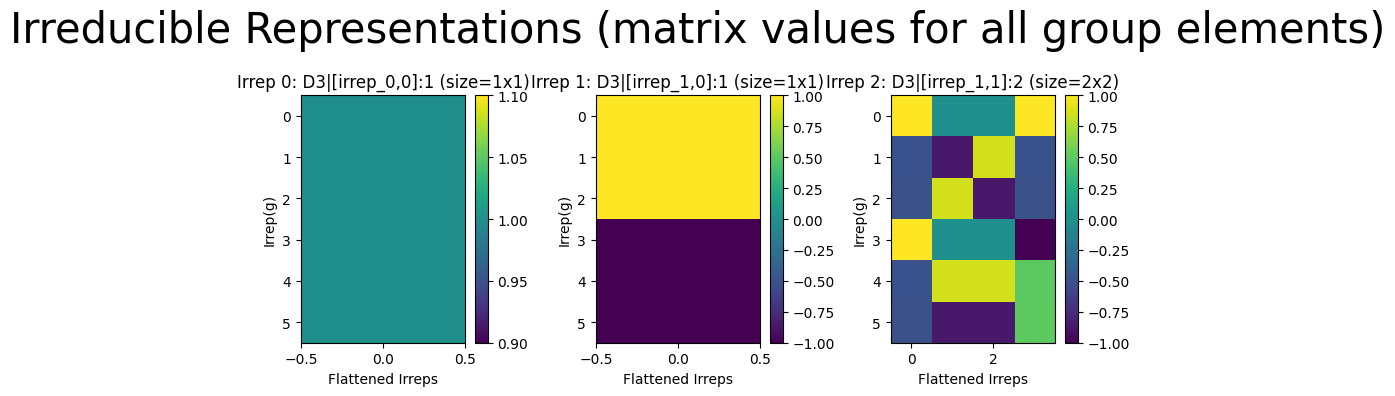

In [9]:
fig = viz.plot_irreps(group, show=False)
plt.savefig(f"{FIGURES_DIR}/dn_irreps.pdf", bbox_inches="tight")
plt.show()